In [2]:
import numpy as np
import scipy as sp
from scipy.stats import poisson, gamma
from scipy.special import gammaln as log_G, gamma as G, factorial as fac, logsumexp
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(12,8)
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "#FFFFFF"


# Radioactive decay

We will be investigating the measurment of the intensity of a radioactive source in the presence of the background nose. 

## The model

The number of registered counts follows the Poisson distribution. For the background it is given by

$$P(k|\lambda_{b}) = e^{-\lambda_{b}}\frac{\lambda_{b}^k }{k!}$$

Where $\lambda_b$ is the background intensity and $t$ is the length of the measurment period. In the following we will set $t=1s$. 

In [3]:
data_b = np.loadtxt('data_b.txt')

In [4]:
# background only
data_b

array([31., 33., 29., 39., 26., 21., 35., 34., 33., 35., 35., 21., 38.,
       25., 36.])

In [5]:
data_b.mean()

31.4

For source and background this given by 
$$P(k|\lambda_{b}, \lambda_{s}) = e^{-(\lambda_{b}+\lambda_{s})t}\frac{(\lambda_{b}+\lambda_s)^k t^k}{k!}$$


In [6]:
data_b_s = np.loadtxt('data_b_s.txt')

In [7]:
# data with source present
data_b_s

array([43., 43., 43., 51., 45., 37., 38., 48., 34., 41.])

In [8]:
data_b_s.mean()

42.3

## Problem 1

### 1.

Write the formula for the  likelihood for the  background intensity measurments $k_1,\ldots,k_{n_b}$. Assuming [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) distribution $\Gamma(\alpha, \beta)$ for $\lambda_b$ prior, write down  the formula for posterior distribution and MAP estimate of $\lambda_b$. __Hint__ Gamma distribution is a conjugate prior to Poisson distribution. 

This is again Gamma distribution (conjugate prior!) but with  different parameters: $\Gamma(\alpha+K, \beta+n_b)$. From [Wikipedia](https://en.wikipedia.org/wiki/Gamma_distributio) :) we find that the mode of $\Gamma(\alpha,\beta)$ distribution is $\frac{\alpha-1}{\beta}$ provided $\alpha\ge 1$.


Because observations are indepentent likelihood is
$$ L(\lambda_b|k) = \prod_{i=1}^{n} e^{-\lambda_b} \frac{\lambda_{b}^{k_i} }{k!} = \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^{n}k_i}}{\prod_{i=1}^{n}k_i!}$$
And log likelihood
$$ log L(\lambda_b|k) = -n\lambda_b + (\sum_{i=1}^{n} k_i) * log(\lambda_b) - \sum_{i=1}^{n}log(k_i!) $$

but we are interested with $\lambda_b$ we can drop last term as it's independent of it. So we get

$$ L(\lambda_b|k) = e^{-n\lambda}\lambda^{\sum_{i=1}^{n}k_i} $$

and

$$ log L(\lambda_b|k) = -n\lambda_b + (\sum_{i=1}^{n} k_i) * log(\lambda_b) $$


Now for posterior

$$ posterior \propto prior * likelihood $$

$\lambda_b$ prior follows gamma distribution:

$$ f(\lambda_b,\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} e^{-\lambda_b \beta} \lambda_b^{(\alpha-1)} $$

then

$$ posterior \propto f(\lambda_b,\alpha,\beta) * L(\lambda_b|k) $$

$$ \frac{\beta^\alpha}{\Gamma(\alpha)} e^{-\lambda_b \beta} \lambda_b^{(\alpha-1)} * e^{-n\lambda}\lambda^{\sum_{i=1}^{n}k_i} $$

$$ \frac{\beta^\alpha}{\Gamma(\alpha)} * e^{-\lambda_b\beta -n\lambda} * \lambda_b^{(\alpha-1)+\sum_{i=1}^{n}ki} = \frac{\beta^\alpha}{\Gamma(\alpha)} * e^{-\lambda_b(\beta +n)} * \lambda_b^{(\alpha-1)+\sum_{i=1}^{n}ki} $$
then finally we get
$$ posterior \propto f(\lambda_b,\alpha+\sum_{i=1}^{n}k_i,\beta + n) $$

MAP estimate:
$$ \lambda_{MAP}(k) $$ 
is estimated as mode of posterior distribution 
$$ \lambda_{MAP}(k) = \frac{\alpha -1 + \sum_{i=1}^{n}ki }{\beta + n} $$


### 2.

Express $\alpha$ and $\beta$ by mean $\mu$ and standard deviation $\sigma$ of the distribution $\Gamma(\alpha,\beta)$. 

In [9]:
import scipy.stats as st
def gamma_md(m,d):
  # assuming m = a/b and d = sqrt(a)/b
  b = m/d**2
  a = m**2/d**2
  # from scipy docs:
  # Note that this parameterization is equivalent to the above, with scale = 1 / beta.
  # return st.gamma.pdf(x,a,scale = 1/b)
  return (a,b,st.gamma(a,scale = 1/b))

  

_,_,test = gamma_md(50,70)

print(test.mean(),test.std())


50.00000000000001 70.00000000000001


Assuming $\mu=50$ and $\sigma=70$ plot the prior and posterior distribution using provided background data and calculate the $\lambda_b$ MAP estimate. __Hint__ Use Gamma distribution from `scipy.stats`.

l_map = 31.400685999999997


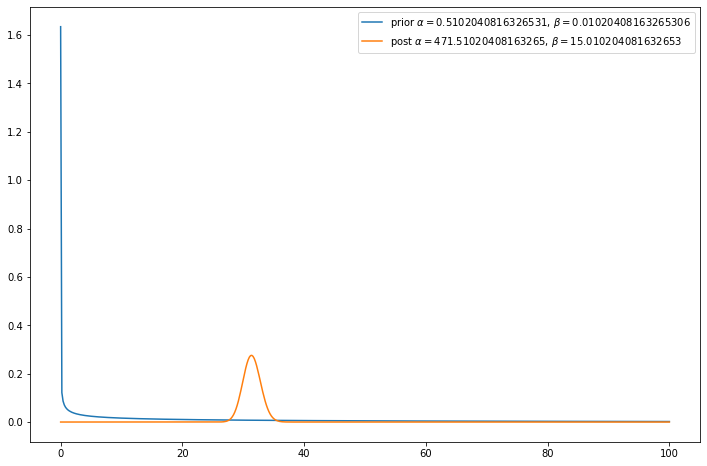

In [10]:
# matplotlib "$\\alpha = 1$"

# first calculate posterior of prior (ie. without data)
# then true posterior with data

def posterior_gamma(lb,a,b,new_data):
  a = a + new_data.sum()
  b = b + len(new_data)
  return (a,b,st.gamma(a,scale = 1/b).pdf(lb))

lb = np.linspace(0.001,100,501)

a,b,prior = gamma_md(50,70)

ap,bp,post = posterior_gamma(lb,a,b,data_b)

l_map = lb[np.argmax(post)]

# import IPython.display as ipd
# ipd.display(ipd.Math('$\lambda_{map} = '+str(l_map)+'$'))
print(f'l_map = {l_map}')

plt.plot(lb,prior.pdf(lb),label = f"prior $\\alpha = {a}$, $\\beta = {b}$")
plt.plot(lb,post,label = f"post $\\alpha = {ap}$, $\\beta = {bp}$")

plt.legend()
plt.show()

## Problem 2

### 1

Write the formula for the  likelihood for the  background intensity measurments $k_1,\ldots,k_{n_b}$. Assuming a uniform distribution in the interval $(0,\lambda_{b,max}]$ for the $\lambda_b$ prior, write down  the formula for MAP estimate of $\lambda_b$.

Continous uniform distribution for $-\infty < a < b < \infty $:
$$ f(x) = \frac{1}{b-a} $$

In our case:
$$ f(\lambda_b) = \frac{1}{\lambda_{b_{max}} - a}  $$

Likelihood function doesn't change compared to previous example but out prior does so new posterior function is:
$$ L(\lambda_b|k) = e^{-n\lambda}\lambda^{\sum_{i=1}^{n}k_i} $$
$$ posterior = prior * likelihood = \frac{1}{\lambda_{b_{max}} - a} * L(\lambda_b|k) $$
And I think we could drop $$\frac{1}{\lambda_{b_{max}}-a}$$ as it doesn't depend on $\lambda_b$ but I'm not sure so I kept it

As for MAP estimate is estimated by mode of posterior distribution, and mode is value that is most likely to be sampled.  
If we drop $\frac{1}{\lambda_{b_{max}} - a}$ from posterior calculation that leaves us with just Poisson distribution and mode of it is 
$$\lfloor\lambda_b\rfloor$$
and mean of Poisson distribution is just $\lambda_b$
So we could also estimate $\lambda_b$ as mean of our data


In [52]:
print(f'l_map ?= {data_b.mean()}')

l_map ?= 31.4


Assuming $\lambda_{b,max}=100.0$ calculate the MAP estimate using all the measurments. What would happen if $\lambda_{b,max}=20.0$ ?

max = 100, l_map = 31.400685999999997
max = 20, l_map = 20.0


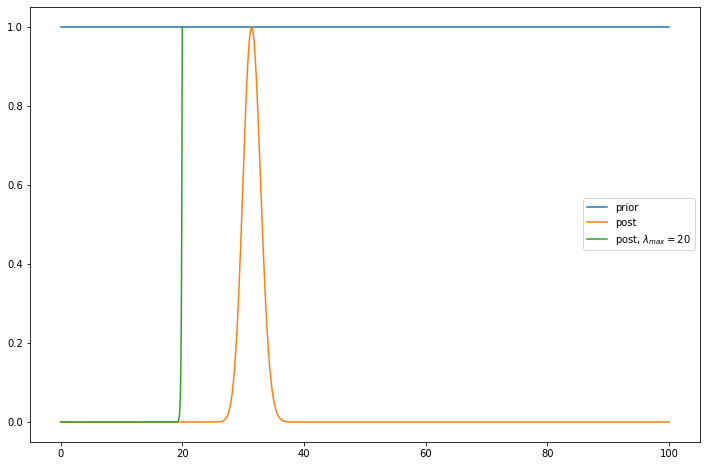

In [50]:
lmax = 100
a = 0.001 # some value close to 0
lb = np.linspace(a,lmax,501)

def log_prior_uni(a,b,lb):
  return np.full(lb.shape,np.log( 1/(b-a) ))

def log_posterior_uni(a,b,lb,data):
  n = len(data)
  K = data.sum()
  return -np.log(b-a) - n * lb + K * np.log(lb)

def normalize_uni(p):
  p-= p.max()
  return np.exp(p)

prior = normalize_uni(log_prior_uni(a,lmax,lb))
post = normalize_uni(log_posterior_uni(a,lmax,lb,data_b))

l_map = lb[np.argmax(post)]
print(f'max = 100, l_map = {l_map}')

plt.plot(lb,prior,label = 'prior')
plt.plot(lb,post,label = 'post')
# plt.legend()
# plt.show()

lmax = 20
lb = np.linspace(a,lmax,501)
prior = normalize_uni(log_prior_uni(a,lmax,lb))
post = normalize_uni(log_posterior_uni(a,lmax,lb,data_b))

l_map = lb[np.argmax(post)]


print(f'max = 20, l_map = {l_map}')
plt.plot(lb,post,label = 'post, $\\lambda_{max} = 20$')
plt.legend()
plt.show()




Mean of Poisson distribution is $\lambda$ and mean of our data_b is $31.4$  
then our $\lambda_{b_{MAP}}$ should be close to mean of data but when we set $\lambda_{b_{max}}$ to 20 which is less than mean it's our best guess

### 2

Implement the formula for likelihood and then for posterior distribution of $\lambda_b$.  Plot the posterior distribution for $\lambda_b$ using 1,2,5,10 and 15 measurments. Use numerical integration for normalization. __Hint__ Use the log-likelihood to deal with numerical issues. 

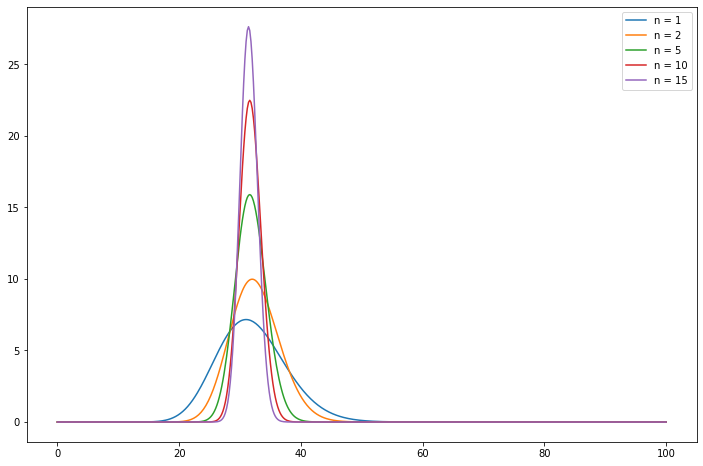

In [161]:
def log_likelihood(ls,data):
  m = len(data)
  K = np.sum(data)
  return -m * ls + K * np.log(ls)

def log_post_likelihood(ls,data,prior):
  return log_likelihood(ls,data) + np.log(prior)

def log_like_b(lb,data):
  return log_likelihood(lb,data)

def log_post_b(ls,data,prior):
  return log_like_b(ls,data) + np.log(prior)

def normalize(p,lb):
  p-= p.max()
  p = np.exp(p)
  # numerical integral // rectangles method
  # p.sum() - combined rectangles height
  # 1/len(lb) - lambda_b step assuming lambdas start from 0- rectangle base
  p = p / (p.sum() * 1/len(lb))
  return p

lb = np.linspace(0.001,100,501)

# prior = 1, because we assume we don't know anything about it
for n in [1,2,5,10,15]:
  p = normalize(log_post_likelihood(lb,data_b[:n],1),lb)
  plt.plot(lb,p,label = f'n = {n}')

# for next exercise
log_lb_prior = normalize(log_post_likelihood(lb,data_b,1),lb)

plt.legend()
plt.show()


### 3

Calculate the mean and standard deviation of each posterior distribution plotted.

In [199]:
lb = np.linspace(0.001,100,501)
for n in [1,2,5,10,15]:
  p = normalize(log_post_likelihood(lb,data_b[:n],1),lb)
  mean = np.sum(lb * p) / np.sum(p)
  std = np.sqrt( (np.sum( (lb - mean)**2 *p) / np.sum(p)))
  print(f'n={n}, mean = {mean}, std = {std}')
  

n=1, mean = 31.999999999999957, std = 5.656854249492119
n=2, mean = 32.499999999999986, std = 4.031128874149273
n=5, mean = 31.8, std = 2.5219040425836883
n=10, mean = 31.70000000000001, std = 1.7804493814764732
n=15, mean = 31.46666666666666, std = 1.448370732160027


## Problem 3

Implement the log-likelihood for $\lambda_b$ and $\lambda_s$ using source plus background data. Then implement the log-posterior for those variables. Use the posterior from the previous problem as $\lambda_b$ prior (using all the data). Use the uniform distribution on $(0,100)$ for $\lambda_s$ prior. Plot the resulting two dimensional function and find the MAP estimates for $\lambda_b$ and $\lambda_s$ for 1,2,3 and 10 measurments of signal and background. 

Given:
$$ P(k|\lambda_{b}, \lambda_{s}) = e^{-(\lambda_{b}+\lambda_{s})}\frac{(\lambda_{b}+\lambda_s)^k}{k!} $$

$$ L(\lambda_b,\lambda_s|k)  = P(k|\lambda_b,\lambda_s) P(\lambda_b,\lambda_s) $$

Assuming:
$$ P(\lambda_b,\lambda_s) = P(\lambda_b)P(\lambda_s) $$

We will use distribution from previous exercise as $P(\lambda_b)$ and beacuse $\lambda_s$ follows uniform dist. and $\lambda_s \in (0,100)$
$$ P(\lambda_s) = \frac{1}{100} $$

Our posterior for $\lambda_b,\lambda_s$ is
$$ P(\lambda_s,\lambda_b |\ k) \propto e^{-(\lambda_{b}+\lambda_{s})}\frac{(\lambda_{b}+\lambda_s)^k}{k!} P(\lambda_b) \frac{1}{100} $$





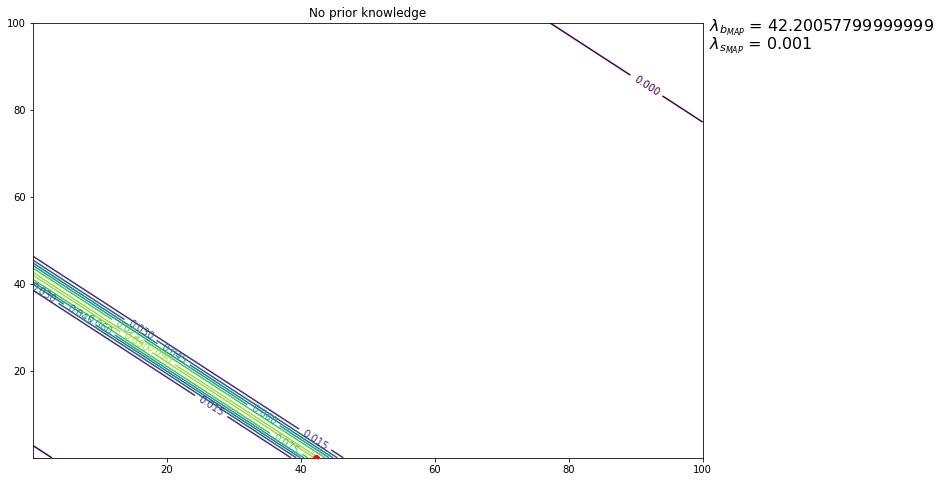

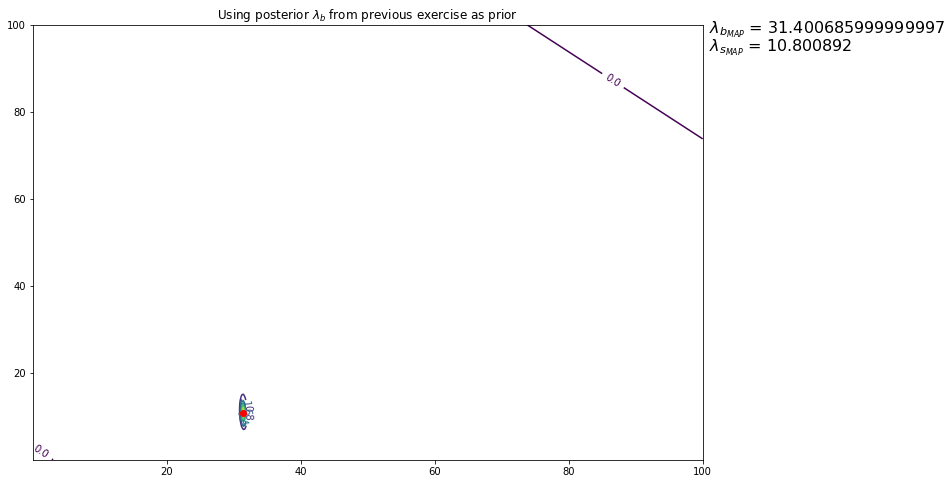

In [175]:
def log_like_bs(lb,ls,data,norm=False):
  n = len(data)
  K = data.sum()
  return -n * (lb+ls) + K * np.log(lb+ls)

def log_post_bs(lb,ls,data,prior_lb,ls_max): 
  # -np.log(ls_max) - ls is uniform distribution => P(ls) = 1/(b-a), where a = 0, b = 100
  p = log_like_bs(lb,ls,data) - np.log(ls_max) + prior_lb
  p -= p.max()
  p = np.exp(p)
  p = p / (p.sum() * 1/len(ls))
  return p

# lb_prior from previous exercise
ln = len(log_lb_prior)
ls_max = 100
ls = np.linspace(0.001,ls_max,ln)
lb = np.linspace(0.001,100,ln)

lb_mesh,ls_mesh = np.meshgrid(lb,ls)

tmp = log_post_bs(lb_mesh,ls_mesh,data_b_s,0,ls_max)

i = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)

ls_map = lb[i[0]]
lb_map = lb[i[1]]
# print(lb_map,ls_map)
plt.text(101,98,'$\\lambda_{b_{MAP}}$ = ' + str(lb_map),fontdict = {'size': 16})
plt.text(101,94,'$\\lambda_{s_{MAP}}$ = ' + str(ls_map),fontdict = {'size': 16})

cs = plt.contour(lb,ls,tmp)
plt.scatter(lb_map,ls_map,c='red',zorder = 10)
plt.clabel(cs)
plt.title('No prior knowledge')
plt.show()

tmp = log_post_bs(lb_mesh,ls_mesh,data_b_s,log_lb_prior,ls_max)

i = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)

ls_map = lb[i[0]]
lb_map = lb[i[1]]
# print(lb_map,ls_map)
plt.text(101,98,'$\\lambda_{b_{MAP}}$ = ' + str(lb_map),fontdict = {'size': 16})
plt.text(101,94,'$\\lambda_{s_{MAP}}$ = ' + str(ls_map),fontdict = {'size': 16})

cs = plt.contour(lb,ls,tmp)
plt.scatter(lb_map,ls_map,c='red',zorder = 10)
plt.title('Using posterior $\\lambda_b$ from previous exercise as prior')

plt.clabel(cs)
plt.show()


In [180]:
ls_max = 100
lb = np.linspace(0.001,100,101)
ls = np.linspace(0.001,ls_max,101)
for n in [1,2,3,5,10]:
  lb_p = log_post_b(lb,data_b[:n],1)
  lb_m,ls_m = np.meshgrid(lb,ls)
  tmp = log_post_bs(lb_m,ls_m,data_b_s[:n],lb_p,ls_max)
  i = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
  ls_map = lb[i[0]]
  lb_map = lb[i[1]]
  print(f'n={n}: ls_map = {ls_map},lb_map = {lb_map}')
  

n=1: ls_map = 12.000879999999999,lb_map = 31.00069
n=2: ls_map = 11.000889999999998,lb_map = 32.000679999999996
n=3: ls_map = 12.000879999999999,lb_map = 31.00069
n=5: ls_map = 13.000869999999999,lb_map = 32.000679999999996
n=10: ls_map = 10.0009,lb_map = 32.000679999999996


How will the estimates change if a friend tells us that he is sure that the source activity is less then 15?

In [183]:
ls_max = 15
lb = np.linspace(0.001,100,101)
ls = np.linspace(0.001,15,101)

lb_p = log_post_b(lb,data_b,1)

lb_m,ls_m = np.meshgrid(lb,ls)
tmp = log_post_bs(lb_m,ls_m,data_b_s,lb_p,ls_max)
i = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
ls_map = lb[i[0]]
lb_map = lb[i[1]]
print(f'ls_map = {ls_map},lb_map = {lb_map}')

ls_map = 75.00025,lb_map = 31.00069


Drastically, unless I did something wrong.